In [7]:
from scipy.special import gamma, factorial
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("../src/")
import mittag_leffler as ml
import integration as itg
from fLe_twobath import fle_twobath
import utils as ut


In [2]:
data_path = "../data/two_baths/"

# Generalized Mittag-Leffler function

$$E_{a,b}^r (z)= \frac{1}{\Gamma(r)}\sum_{k=0}^{\infty}\frac{\Gamma(k+r)}{k!\Gamma(ak+b)} z^k$$

In [83]:
def prabhakar_mittag_leffler(z, a, b, r, inf = 100):
    """This function evaluates the Prabhakar Mittag-Leffler function (MFF) of at a real value z
   
    Parameters
    ----------
    z : float64
        Evaluation point
    a : float64
        a coefficient of the MFF function. Now limited to real values but should admit complex values
    b : float64
        b coefficient of the MFF function. Now limited to real values but should admit complex values
    r : float64
        b coefficient of the MFF function. Now limited to real values but should admit complex values
    inf : int64
        Sufficiently large value for the  summation on the definition (in general 100 is enough to vanis 1/gamma dependency)
    """
    s_k = np.zeros(inf)
    k = np.arange(0, inf, 1, dtype=int)
    return (z**k/gamma(a*k + b)*(gamma(k+r)/gamma(k+1))).sum()*(1/gamma(r))

In [84]:
def Prabhakar_mittag_leffler(vect, a, b, r, inf = 100):
    """This function evaluates the Mittag-Leffler function (MFF) in a 1xn numpy array
    In principle, this is the most computational efficient way of evaluation 
    (See: https://stackoverflow.com/questions/35215161/most-efficient-way-to-map-function-over-numpy-array)
    
    Parameters
    ----------
    vect : 1xn numpy array 
        Evaluation vector
    a : float64
        a coefficient of the MFF function. Now limited to real values but should admit complex values
    b : float64
        b coefficient of the MFF function. Now limited to real values but should admit complex values
    r : float64
        b coefficient of the MFF function. Now limited to real values but should admit complex values
    inf : int64
        Sufficiently large value for the  summation on the definition (in general 100 is enough to vanis 1/gamma dependency)
    """
    pmtlf = lambda x: prabhakar_mittag_leffler(x, a, b, r, inf)
    v_pmtlf = np.vectorize(pmtlf)
    return v_pmtlf(vect)

In [208]:
def get_analytical(fle):
        H = fle.H
        eta_H = fle.eta
        M = fle.A
        eta_12 = fle.C      
        t = fle.t
        noise = fle.dB
        v0 =fle.v0
                
        t__ = np.array(t)
        noise__ = np.array(noise)
        
        def relaxation_function(t):            
            order = 2 - 2*H
            z = -(eta_H/M)*t**(2-order)
            G = pd.DataFrame()
            inf = 10
            for n in range(inf):
                G[f"n{n}"] = Prabhakar_mittag_leffler(z, 2-order, 2, n+1) * t * ((-eta_12/M)**n)
            
            return np.array(G.sum(axis = 1))
        
        def relaxation_function_(t):            
            order = 2 - 2*H
            z = -(eta_H/M)*t
            G = pd.DataFrame()
            inf = 40
            for n in range(inf):
                t_ = ((-eta_12/M)**n)*t**((2-order)*n+1)
                G[f"n{n}"] = Prabhakar_mittag_leffler(z, 1 , (2-order)* n + 2, n+1) * t_ 
            
            return np.array(G.sum(axis = 1))
        
        conv = itg.convolution(relaxation_function_, noise__, t__)
        
        nonlinear = v0 * relaxation_function_(t__)
        
        analytical = nonlinear + (1/M) * conv
        

In [209]:
# Next-guess algorithm
def inspect_nga(H, N, id):
    return ut.read_hdf5_data(f"{data_path}two_baths-h-{H}-{N}-{id}.hdf5")

In [216]:
H = 0.8
N = 280
T = 20
id = 4

In [217]:
path_H = (f"{data_path}fBM-h-{H}-{N}-{id}.hdf5")
path_12 = (f"{data_path}fBM-h-0.5-{N}-{id}.hdf5")
noise_path = (f"{data_path}two_baths-h-{H}-noise{N}-{id}.hdf5")

BH = ut.read_hdf5_data(path_H)
B12 = ut.read_hdf5_data(path_12)
B = np.array(BH.deets_v) + np.array(B12.deets_v)

dBH = ut.read_hdf5_data(noise_path)

t = dBH.deets_t
noise = dBH.deets_v

order = 2-2*H
v0 = 0
delta_t = T/N

fle = fle_twobath(H)
fle.params(T, h = delta_t, v0 = 0)#first_guess_[2]/delta_t)
fle.external_B(B, t)
fle.solve()

Text(0.5, 1.0, 'H = 0.8')

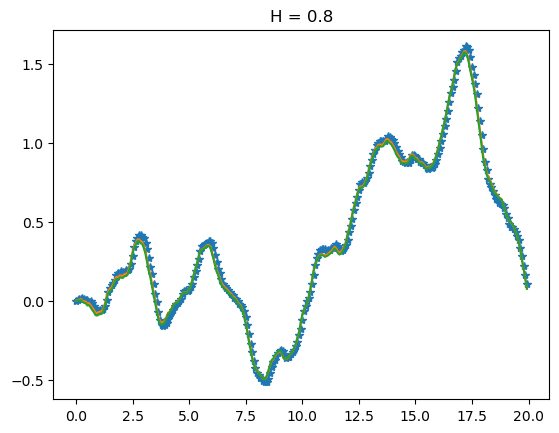

In [219]:
fig, ax = plt.subplots()
nga = inspect_nga(H, N, id)
anl = get_analytical(fle)

ax.plot(nga.deets_t, nga.deets_v, ls = "", marker = "*", label = "Next-guess algorithm")
ax.plot(fle.t, fle.numerical, label = "Finite difference")
ax.plot(fle.t, anl, label = "Analytical")
ax.set_title(f"H = {H}")

Text(0.5, 1.0, 'H = 0.51')

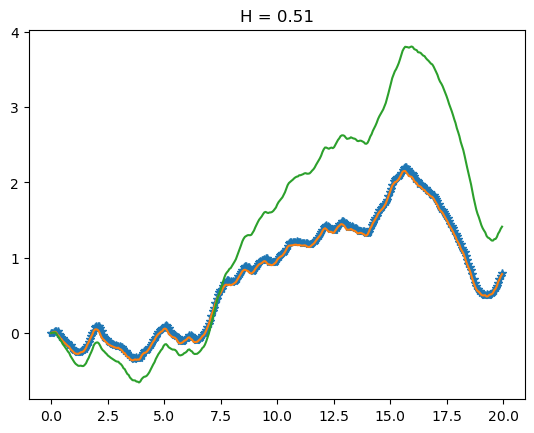

In [119]:
fig, ax = plt.subplots()
nga = inspect_nga(H, N, id)

ax.plot(nga.deets_t, nga.deets_v, ls = "", marker = "*", label = "Next-guess algorithm")
ax.plot(fle.t, fle.numerical, label = "Finite difference")
ax.plot(fle.t, anl, label = "Analytical")
ax.set_title(f"H = {H}")